# Permutation tests when a sample = a time at t?

This notebook is with a version $t_{i+1} = t_i + N(\mu, \sigma)$

- first date: 12.August.2021
- updated date: 23.August.2021

In [1]:
import sys
sys.path.append("../")
sys.path.append(".")

In [2]:
from model_criticism_mmd import ModelTrainerTorchBackend, MMD, TwoSampleDataSet
from model_criticism_mmd import kernels_torch
from model_criticism_mmd import PermutationTest, SelectionKernels

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [3]:
import torch
device_obj = torch.device('cpu')

# Data preparations

In [4]:
import numpy as np
import tqdm

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
N_DATA_SIZE = 500
N_TIME_LENGHTH = 100
NOISE_MU_X = 0
NOISE_SIGMA_X = 0.5
NOISE_MU_Y = 0
NOISE_SIGMA_Y = 0.5

N_EPOCHS = 10
N_PERMUTATIONS = 500

In [7]:
INITIAL_VALUE_AT_ONE = np.random.normal(0, 0.5, (N_DATA_SIZE,))

In [8]:
x_data_sample = np.zeros((N_DATA_SIZE, N_TIME_LENGHTH))
y_data_sample = np.zeros((N_DATA_SIZE, N_TIME_LENGHTH))
y_data_sample_laplace = np.zeros((N_DATA_SIZE, N_TIME_LENGHTH))

x_data_sample[:, 0] = INITIAL_VALUE_AT_ONE
y_data_sample[:, 0] = INITIAL_VALUE_AT_ONE
y_data_sample_laplace[:, 0] = INITIAL_VALUE_AT_ONE

for time_t in tqdm.tqdm(range(0, N_TIME_LENGHTH - 1)):
    noise_x = np.random.normal(NOISE_MU_X, NOISE_SIGMA_X, (N_DATA_SIZE,))
    noise_y = np.random.normal(NOISE_MU_Y, NOISE_SIGMA_X, (N_DATA_SIZE,))
    noise_y_laplace = np.random.laplace(NOISE_MU_Y, NOISE_SIGMA_X, (N_DATA_SIZE,))
    
    x_data_sample[:, time_t + 1] = x_data_sample[:, time_t].flatten() + noise_x
    y_data_sample[:, time_t + 1] = y_data_sample[:, time_t].flatten() + noise_y
    y_data_sample_laplace[:, time_t + 1] = y_data_sample_laplace[:, time_t].flatten() + noise_y_laplace
    # end if
assert x_data_sample.shape == (N_DATA_SIZE, N_TIME_LENGHTH)
assert y_data_sample.shape == (N_DATA_SIZE, N_TIME_LENGHTH)
assert np.array_equal(x_data_sample, y_data_sample) is False

100%|██████████| 99/99 [00:00<00:00, 8200.74it/s]


In [9]:
import pandas

<AxesSubplot:title={'center':'Feature distribution in X'}, ylabel='Frequency'>

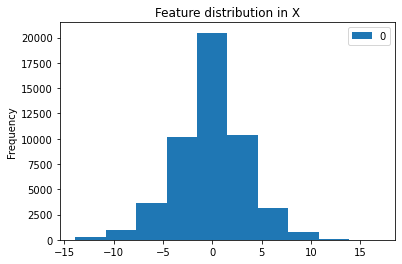

In [10]:
pandas.DataFrame(x_data_sample.flatten()).plot(kind='hist', title='Feature distribution in X')

<AxesSubplot:title={'center':'Feature distribution in Y'}, ylabel='Frequency'>

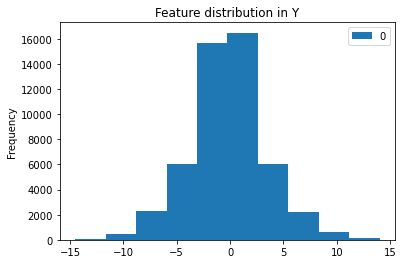

In [11]:
pandas.DataFrame(y_data_sample.flatten()).plot(kind='hist', title='Feature distribution in Y')

In [12]:
assert np.array_equal(x_data_sample, y_data_sample) is False, 'x and y are same. Should be different!'

Now, we confirmed that X and Y are very similar, but not same.

# Pre-experiment: X and Y is same when a sample = an observation?

We suppose that we have 500 time-series which has 350 features.

In [13]:
print(f"X(observation * time-length){x_data_sample.shape} Y(observation * time-length){y_data_sample.shape}")

X(observation * time-length)(500, 100) Y(observation * time-length)(500, 100)


<AxesSubplot:title={'center':'x in time-series sequence'}>

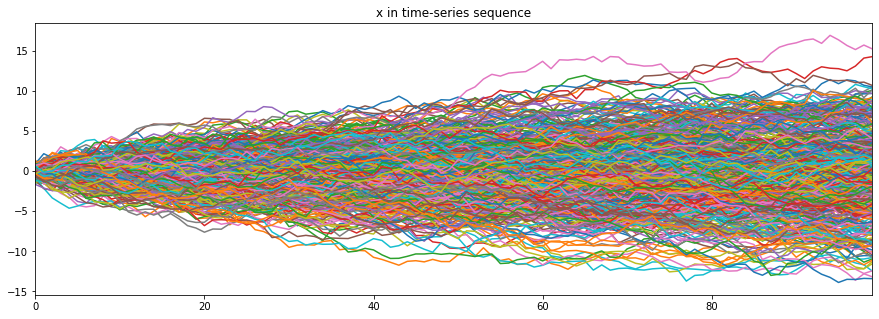

In [14]:
pandas.DataFrame(x_data_sample).transpose().plot(kind='line', legend=False, figsize=(15, 5), title='x in time-series sequence')

<AxesSubplot:title={'center':'y in time-series sequence'}>

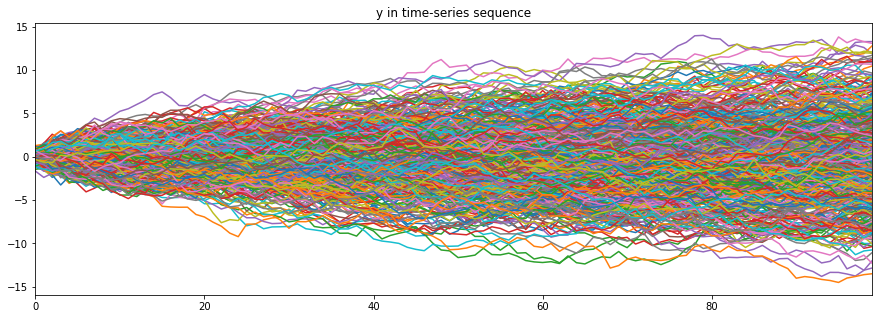

In [15]:
pandas.DataFrame(y_data_sample).transpose().plot(kind='line', legend=False, figsize=(15, 5), title='y in time-series sequence')

<AxesSubplot:title={'center':'y-laplace in time-series sequence'}>

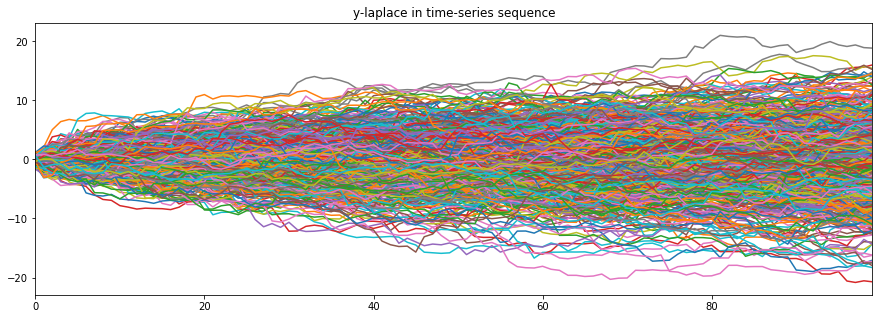

In [16]:
pandas.DataFrame(y_data_sample_laplace).transpose().plot(kind='line', legend=False, figsize=(15, 5), title='y-laplace in time-series sequence')

## Kernels

In [17]:
rbf_kernel = kernels_torch.BasicRBFKernelFunction(device_obj=device_obj, log_sigma=-1.0)
matern_0_5 = kernels_torch.MaternKernelFunction(nu=0.5, device_obj=device_obj, lengthscale=-1.0)
matern_1_5 = kernels_torch.MaternKernelFunction(nu=1.5, device_obj=device_obj, lengthscale=-1.0)
matern_2_5 = kernels_torch.MaternKernelFunction(nu=2.5, device_obj=device_obj, lengthscale=-1.0)

kernels_optimization = [(None, rbf_kernel), (None, matern_0_5), (None, matern_1_5), (None, matern_2_5)]
kernels_non_optimization = [rbf_kernel, matern_2_5]

In [18]:
from model_criticism_mmd.supports import TestResultGroupsFormatter, StatsTestEvaluator

In [19]:
stats_evaluator = StatsTestEvaluator(candidate_kernels=kernels_optimization, 
                                     num_epochs=N_EPOCHS, 
                                     n_permutation_test=N_PERMUTATIONS, 
                                     kernels_no_optimization=kernels_non_optimization)

# Experiment 1: A sample is a detector

In [20]:
evals_data_sample = stats_evaluator.interface(code_approach='sample=detector', 
                                              x=x_data_sample, 
                                              y_same=y_data_sample, 
                                              y_diff=y_data_sample_laplace)

2021-08-24 17:04:25,770 - model_criticism_mmd.logger_unit - INFO - Set the initial scales value
../model_criticism_mmd/backends/backend_torch.py:285: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor(init_scale.clone().detach().cpu(), requires_grad=True, device=self.device_obj)
2021-08-24 17:04:25,774 - model_criticism_mmd.logger_unit - INFO - Getting median initial sigma value...
2021-08-24 17:04:25,873 - model_criticism_mmd.logger_unit - INFO - initial by median-heuristics 3.47 with is_log=True
2021-08-24 17:04:25,891 - model_criticism_mmd.logger_unit - INFO - Validation at 0. MMD^2 = 0.00637597514835786, ratio = [63.75975148] obj = [-4.15512214]
2021-08-24 17:04:26,692 - model_criticism_mmd.logger_unit - INFO -      5: [avg train] MMD^2 0.004653008560123517 obj [-2.01896427] val-MMD^2 0.006438235237476109 val-ratio 

# Experiment 2: permutation test when a sample is a time-series

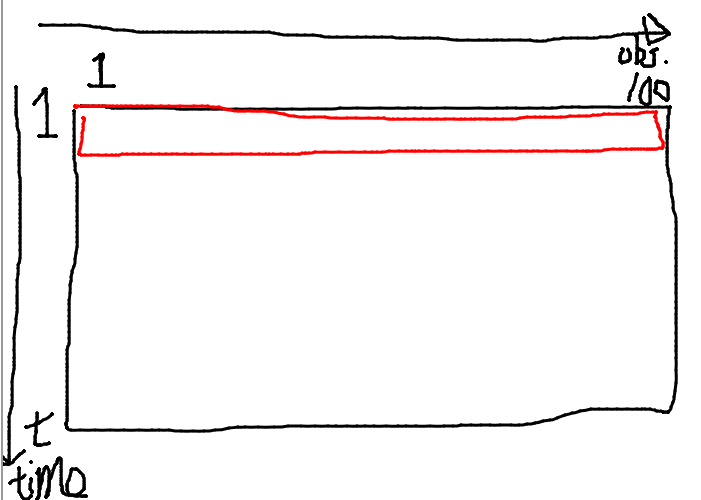

## X = Y

First, we transpose the matrix. With the transpose, one sample is one time-series.

In [29]:
x_time_sample = x_data_sample.transpose()
y_time_sample = y_data_sample.transpose()
y_time_laplace = y_data_sample_laplace.transpose()

In [30]:
print(f'shape of x (time-length * data): {x_time_sample.shape}, shape of y (time-length * data): {y_time_sample.shape}')

shape of x (time-length * data): (100, 500), shape of y (time-length * data): (100, 500)


In [31]:
evals_time_sample = stats_evaluator.interface(code_approach='sample=time', 
                                              x=x_time_sample, 
                                              y_same=y_time_sample, 
                                              y_diff=y_time_laplace)

2021-08-24 17:06:44,414 - model_criticism_mmd.logger_unit - INFO - Set the initial scales value
../model_criticism_mmd/backends/backend_torch.py:285: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor(init_scale.clone().detach().cpu(), requires_grad=True, device=self.device_obj)
2021-08-24 17:06:44,418 - model_criticism_mmd.logger_unit - INFO - Getting median initial sigma value...
2021-08-24 17:06:44,447 - model_criticism_mmd.logger_unit - INFO - initial by median-heuristics 4.16 with is_log=True
2021-08-24 17:06:44,463 - model_criticism_mmd.logger_unit - INFO - Validation at 0. MMD^2 = 1.6832609368703848, ratio = [133.82379642] obj = [-4.89652398]
2021-08-24 17:06:44,908 - model_criticism_mmd.logger_unit - INFO -      5: [avg train] MMD^2 0.723385954890138 obj [-2.81459501] val-MMD^2 1.6832994319213932 val-ratio [133.

# Experiment 3: permutation test when a sample is a time-series (with index)

In [32]:
x_time_sample = x_data_sample.transpose()
y_time_sample = y_data_sample.transpose()
y_time_sample_laplace = y_data_sample_laplace.transpose()

In [33]:
x_time_sample_index = np.concatenate([
    x_time_sample,
    np.arange(0, len(x_time_sample)).reshape((len(x_time_sample), 1))
], axis=1)

y_time_sample_index = np.concatenate([
    y_time_sample,
    np.arange(0, len(y_time_sample)).reshape((len(y_time_sample), 1))
], axis=1)

y_time_sample_laplace_index = np.concatenate([
    y_time_sample_laplace,
    np.arange(0, len(y_time_sample_laplace)).reshape((len(y_time_sample_laplace), 1))
], axis=1)

In [34]:
evals_time_sample_index = stats_evaluator.interface(code_approach='sample=time(index)', 
                                              x=x_time_sample_index, 
                                              y_same=y_time_sample_index, 
                                              y_diff=y_time_sample_laplace_index)

2021-08-24 17:07:32,563 - model_criticism_mmd.logger_unit - INFO - Set the initial scales value
../model_criticism_mmd/backends/backend_torch.py:285: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor(init_scale.clone().detach().cpu(), requires_grad=True, device=self.device_obj)
2021-08-24 17:07:32,569 - model_criticism_mmd.logger_unit - INFO - Getting median initial sigma value...
2021-08-24 17:07:32,596 - model_criticism_mmd.logger_unit - INFO - initial by median-heuristics 4.26 with is_log=True
2021-08-24 17:07:32,602 - model_criticism_mmd.logger_unit - INFO - Validation at 0. MMD^2 = 1.6243108024570305, ratio = [130.36773612] obj = [-4.8703592]
2021-08-24 17:07:33,013 - model_criticism_mmd.logger_unit - INFO -      5: [avg train] MMD^2 0.64018032290242 obj [-2.76136939] val-MMD^2 1.6245147059972338 val-ratio [130.55

In [36]:
formatter_obj = TestResultGroupsFormatter(evals_data_sample + evals_time_sample)
formatter_obj.format_result_table()

RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment

Let's visualize the time-series of X and Y.